# Machine Learning Talks
## Genetic Algorithms applied to Cluster Analysis on Football Players

This notebook was developed by Paulo Branco for the Cleverti's Machine Learning Talks. In this talk I'm going introduce you to Genetic Algorithms, first with a brief teorical introduction, following by a small example developed in python where GA is applied to the practical example presented in the first session by André Miranda.

Hope you like it!
Dataset source: https://www.kaggle.com/karangadiya/fifa19

In [69]:
# IMPORTING MODULES
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import cluster
from sklearn.metrics import silhouette_score

### Import data

In [70]:
player_data = pd.read_csv('data.csv')  # imports the CSV file with the player data from FIFA 19
player_data.set_index('Name', inplace=True)  # sets players's name as index
player_data.drop(['Unnamed: 0', 'ID'], axis=1, inplace=True)  # remove useless columns

print(player_data.shape)  # data dimensions
print(player_data.columns) # columns available

(18207, 86)
Index(['Age', 'Photo', 'Nationality', 'Flag', 'Overall', 'Potential', 'Club',
       'Club Logo', 'Value', 'Wage', 'Special', 'Preferred Foot',
       'International Reputation', 'Weak Foot', 'Skill Moves', 'Work Rate',
       'Body Type', 'Real Face', 'Position', 'Jersey Number', 'Joined',
       'Loaned From', 'Contract Valid Until', 'Height', 'Weight', 'LS', 'ST',
       'RS', 'LW', 'LF', 'CF', 'RF', 'RW', 'LAM', 'CAM', 'RAM', 'LM', 'LCM',
       'CM', 'RCM', 'RM', 'LWB', 'LDM', 'CDM', 'RDM', 'RWB', 'LB', 'LCB', 'CB',
       'RCB', 'RB', 'Crossing', 'Finishing', 'HeadingAccuracy', 'ShortPassing',
       'Volleys', 'Dribbling', 'Curve', 'FKAccuracy', 'LongPassing',
       'BallControl', 'Acceleration', 'SprintSpeed', 'Agility', 'Reactions',
       'Balance', 'ShotPower', 'Jumping', 'Stamina', 'Strength', 'LongShots',
       'Aggression', 'Interceptions', 'Positioning', 'Vision', 'Penalties',
       'Composure', 'Marking', 'StandingTackle', 'SlidingTackle', 'GKDiving',
   

### Data Preparation

In [71]:
# We are going to filter the players for our analysis
player_data_raw = player_data  # we'll keep the raw data for later
player_data = player_data[player_data['Overall'] > 82]  # filter the best players
player_data = player_data[player_data['Position'] != 'GK'] # removes Goal Keepers
features_to_keep = [
    'Crossing', 'Finishing', 'HeadingAccuracy', 'ShortPassing', 'Volleys', 'Dribbling',
    'Curve', 'FKAccuracy', 'LongPassing', 'BallControl', 'Acceleration', 'SprintSpeed', 'Agility', 'Reactions',
    'Balance', 'ShotPower', 'Jumping', 'Stamina', 'Strength', 'LongShots', 'Aggression', 'Interceptions',
    'Positioning', 'Vision', 'Penalties', 'Composure', 'Marking', 'StandingTackle', 'SlidingTackle'
]
player_data = player_data[features_to_keep]  # keep only the chosen features
print(player_data.shape)  # data dimensions
data_matrix = player_data[list(player_data.columns)[2:]].values  #  gets the feature's data in a matrix format for model input

(193, 29)


In [72]:
display(data_matrix)

array([[70., 90., 86., ..., 33., 28., 26.],
       [89., 81., 87., ..., 28., 31., 23.],
       [62., 84., 84., ..., 27., 24., 33.],
       ...,
       [70., 86., 73., ..., 75., 82., 70.],
       [41., 83., 79., ..., 31., 25., 26.],
       [81., 81., 74., ..., 90., 82., 80.]])

In [73]:
model = cluster.KMeans(n_clusters=5)
model.fit(data_matrix)  # train the model
labels = model.labels_  # get the clusters for each player

In [74]:
score = silhouette_score(X=data_matrix, labels=labels, metric='euclidean')
print(f'\nSilhouette Coefficient:', score)


Silhouette Coefficient: 0.2306625166385285


### Genetic Algorithm (GA)
Now we are going to start our GA to try to select one good set of features to train the model. This is a custom implementation just for learning proposes.
#### GA parameters

In [75]:
crossover_prob = 0.8  # crossover probability 
mutation_prob = 0.2  # mutation probability
iterations = 100  # number of generations
pool_size = 50  # population size

#### Some variables initialization

In [76]:
pool = np.array([]) # population array
pool_old_gen = np.array([])  # parents population array (auxiliary)
scores_old_gen = list()  # parents scores array
fitness_old_gen = list()  # parents fitness array
iterations_results = {}  # needed to show results chart

#### Population Initialization
We are going to use the random approach

In [77]:
pool = np.random.randint(0, 2, (pool_size, data_matrix.shape[1]))
display(pool)

array([[1, 1, 1, ..., 0, 1, 1],
       [0, 0, 1, ..., 0, 0, 1],
       [1, 0, 1, ..., 1, 1, 0],
       ...,
       [1, 0, 1, ..., 1, 0, 1],
       [1, 1, 1, ..., 0, 0, 0],
       [0, 1, 1, ..., 1, 1, 0]])

In [78]:
# start the iterations
for iteration in range(0, iterations + 1):
    start_time = time.time()
    scores = list()
    fitness = list()

    # calculate the fitness of each chromosome
    # in the fitness function will use the Silhouette Coefficient to calculate the score of the model -> [-1, 1]
    # The Silhouette Coefficient is calculated using the mean intra-cluster distance (a) and the mean nearest-cluster distance (b) for each sample. 
    # The Silhouette Coefficient for a sample is (b - a) / max(a, b). 
    # To clarify, b is the distance between a sample and the nearest cluster that the sample is not a part of.
    for chromosome in pool:
        features_idx = [idx for idx, gene in enumerate(chromosome) if gene == 1]
        adj_data_matrix = np.array(data_matrix[:, features_idx])

        # train the model
        model.fit(adj_data_matrix)
        labels = model.labels_
        score = silhouette_score(X=adj_data_matrix, labels=labels, metric='euclidean')
        scores.append(score)
        fitness = [x / sum(scores) for x in scores]
        # print('Chromossome: {} -> {}'.format(chromosome, score))

    #  check if exists an older generation. If yes, he performs the next generation selection based in the fitness
    if len(pool_old_gen) > 0:
        off_t = list(zip(fitness, scores, pool))
        pool_t = list(zip(fitness_old_gen, scores_old_gen, pool_old_gen))
        pool_tuple = np.array(sorted(off_t + pool_t, key=lambda x: x[1], reverse=True))[:pool_size]
        fitness = [x[0] for x in pool_tuple]
        scores = [x[1] for x in pool_tuple]
        pool = [x[2] for x in pool_tuple]

        # store scores for statistics
        iterations_results['{}'.format(iteration)] = dict()
        iterations_results['{}'.format(iteration)]['fitness'] = fitness
        iterations_results['{}'.format(iteration)]['pool'] = pool
        iterations_results['{}'.format(iteration)]['scores'] = scores

    offspring = list()

    # execute the genetic operations
    if iteration < iterations:
        for idx in range(int(pool_size / 2)):
            # select the parents randomly (there are several methods: roulette, tournament, rank, random)
            parent_1 = pool[np.random.randint(0, pool_size)]
            parent_2 = pool[np.random.randint(0, pool_size)]

            # execute the crossover operation according its probability
            # the method used is 1-point, but other methods exists, ex: multi-point
            if np.random.random() < crossover_prob:
                random_split_point = np.random.randint(1, len(parent_1))
                child_1 = np.concatenate((parent_1[:random_split_point], parent_2[random_split_point:]), axis=0)
                child_2 = np.concatenate((parent_2[:random_split_point], parent_1[random_split_point:]), axis=0)
            else:
                # if we dont execute x-over, the parents are used for next steps
                child_1 = parent_1[:]
                child_2 = parent_2[:]

            # execute mutation in each gene according its probability
            for idx, gene in enumerate(child_1):
                if np.random.random() < mutation_prob:
                    child_1[idx] = 1 - gene

            for idx, gene in enumerate(child_2):
                if np.random.random() < mutation_prob:
                    child_2[idx] = 1 - gene

            # add the new childs to the offspring
            offspring.append(child_1)
            offspring.append(child_2)
        # save the parents generation
        pool_old_gen = pool[:]
        scores_old_gen = scores[:]
        fitness_old_gen = fitness[:]
        # store the new offspring (but the new generation was not selected yet)
        pool = offspring[:]

        # print progression
        if iteration % 10 == 0 and iteration > 0:
            end_time = time.time()
            print('Iteration {} Complete [Time Taken For Last Iteration: {}]'
                  .format(iteration, round(end_time - start_time, 2)))
            
# print last iteration
print('Iteration {} Complete [Time Taken For Last Iteration: {}]'
                  .format(iteration, round(time.time() - start_time, 2)))

Iteration 10 Complete [Time Taken For Last Iteration: 1.36]
Iteration 20 Complete [Time Taken For Last Iteration: 1.32]
Iteration 30 Complete [Time Taken For Last Iteration: 1.35]
Iteration 40 Complete [Time Taken For Last Iteration: 1.36]
Iteration 50 Complete [Time Taken For Last Iteration: 1.35]
Iteration 60 Complete [Time Taken For Last Iteration: 1.38]
Iteration 70 Complete [Time Taken For Last Iteration: 1.4]
Iteration 80 Complete [Time Taken For Last Iteration: 1.86]
Iteration 90 Complete [Time Taken For Last Iteration: 1.54]
Iteration 100 Complete [Time Taken For Last Iteration: 1.45]


#### Print the result


Chosen solution:
(array([1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1,
       0, 0, 0, 1, 1]), [0, 4, 5, 6, 7, 8, 10, 11, 12, 13, 14, 17, 20, 21, 25, 26])


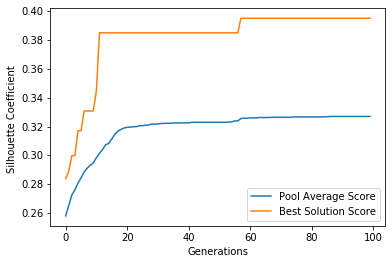

In [79]:
# print result
solution = pool[0], [idx for idx, gene in enumerate(pool[0]) if gene == 1]
print('\nChosen solution:')
print(solution)

# plot the process chart
%matplotlib inline
avs = [np.mean(iterations_results[str(x)]['scores']) for x in range(1, iterations + 1)]
avs0 = [np.mean(iterations_results[str(x)]['scores'][0]) for x in range(1, iterations + 1)]
plt.plot(avs, label='Pool Average Score')
plt.plot(avs0, label='Best Solution Score')
plt.legend()
plt.xlabel('Generations')
plt.ylabel('Silhouette Coefficient ')
plt.show()

### Train the model with the features selected

In [80]:
data_matrix = np.array(data_matrix[:, solution[1]])  # Filter the data_matrix with the features selected
model.fit(data_matrix)  # train the model
labels = model.labels_  # get the clusters for each player

#### Print results

In [81]:
results = pd.DataFrame(labels, index=player_data.index, columns=['cluster_number'])
player_data = player_data.join(results)

for nr in range(6):
    print(f'\nPlayers in cluster number {nr}')
    print(player_data[player_data['cluster_number'] == nr].index)

score = silhouette_score(X=data_matrix, labels=labels, metric='euclidean')
print(f'\nSilhouette Coefficient:', score)


Players in cluster number 0
Index(['Cristiano Ronaldo', 'R. Lewandowski', 'H. Kane', 'E. Cavani',
       'P. Aubameyang', 'G. Higuaín', 'M. Icardi', 'R. Lukaku', 'C. Immobile',
       'T. Müller', 'E. Džeko', 'Diego Costa', 'K. Benzema', 'Z. Ibrahimović',
       'Jonas', 'Falcao', 'Louri Beretta', 'T. Werner', 'Gerard Moreno',
       'Rodrigo', 'B. Dost', 'M. Balotelli'],
      dtype='object', name='Name')

Players in cluster number 1
Index(['Sergio Ramos', 'N. Kanté', 'Sergio Busquets', 'Casemiro', 'M. Hummels',
       'Marcelo', 'Thiago Silva', 'S. Umtiti', 'Jordi Alba', 'J. Vertonghen',
       'V. van Dijk', 'M. Verratti', 'Alex Sandro', 'Azpilicueta',
       'L. Bonucci', 'T. Alderweireld', 'Fernandinho', 'S. Milinković-Savić',
       'J. Kimmich', 'Saúl', 'D. Alaba', 'Paulinho', 'A. Vidal', 'S. Khedira',
       'R. Nainggolan', 'Naldo', 'B. Matuidi', 'Filipe Luís', 'Alex Telles',
       'Fabinho', 'William Carvalho', 'Carvajal', 'N. Matić', 'Illarramendi',
       'K. Walker', 'M.

#### Use our model to predict

In [82]:
# prediction phase
player_to_predict = player_data_raw.loc[['Óliver Torres', 'J. Mathieu', 'Rafa']]
player_to_predict = player_to_predict[features_to_keep]
display(player_to_predict)

prediction_data_matrix = player_to_predict[list(player_to_predict.columns)[2:]].values
prediction_data_matrix = np.array(prediction_data_matrix[:, solution[1]])
predicted_labels = model.predict(prediction_data_matrix)
predictions = pd.DataFrame(predicted_labels, index=player_to_predict.index, columns=['cluster_number'])
display(predictions)

,Crossing,Finishing,HeadingAccuracy,ShortPassing,Volleys,Dribbling,Curve,FKAccuracy,LongPassing,BallControl,...,LongShots,Aggression,Interceptions,Positioning,Vision,Penalties,Composure,Marking,StandingTackle,SlidingTackle
Name,,,,,,,,,,,,,,,,,,,,,
Óliver Torres,73.0,70.0,52.0,81.0,60.0,83.0,77.0,64.0,78.0,82.0,...,69.0,58.0,67.0,76.0,80.0,64.0,82.0,66.0,66.0,62.0
J. Mathieu,79.0,52.0,80.0,73.0,61.0,65.0,82.0,75.0,77.0,62.0,...,74.0,72.0,82.0,58.0,58.0,72.0,76.0,86.0,84.0,82.0
Rafa,77.0,66.0,46.0,75.0,64.0,86.0,76.0,56.0,64.0,84.0,...,61.0,41.0,43.0,78.0,75.0,59.0,77.0,23.0,38.0,31.0


,cluster_number
Name,
Óliver Torres,4
J. Mathieu,1
Rafa,3



### Conclusion

With this example we can see how a Genetic Algorithm can be applied to a Machine Learning Algorithm as KMeans in Features Reduction phase. In this case the Fitness function was implemented using the  Silhouette Coefficient.

Try it yourself!

You can try to tweak some parameters in the notebook and check how the model responds to that. Try changing:

- Changing GA parameters
- Changing fitness function
- Changing parents selection and crossover method

Have fun! Any question, I'll try to help.
